In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats as st
from itertools import accumulate
import numpy as np
import math 
from mpl_toolkits.mplot3d import Axes3D

## 

In [8]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

def plot_dist(x,y):
    ''' plotting environment we frequently use to visualise the 
    sampling algorithms.'''
    
    sns.set_style('white')
    plt.rcdefaults()

    # plot contour
    g = (sns.JointGrid(x, y, size=10).plot_joint(sns.kdeplot, n_levels=4, cmap="BuPu", shade=True, shade_lowest=False))

    # add scatter plot of data
    g = g.plot_joint(plt.scatter, c="r", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='', alpha=0.4, )
    
    # set axis labels
    g.set_axis_labels("$X$", "$Y$")
    
def traceplot(x):
    '''traceplot in the x-dimension with the cumulative mean (r)
    and the actual mean (--)'''
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')
    
def autocorrelation_plot(x, l):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l,  normed=True, usevlines=False);
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')


In [9]:
# set mean and covariance for Q
mean = np.array([0, 1])
var = np.array([[1, .5], [.5, 1]])

Text(0.5, 0, '$\\pi(x,y)$')

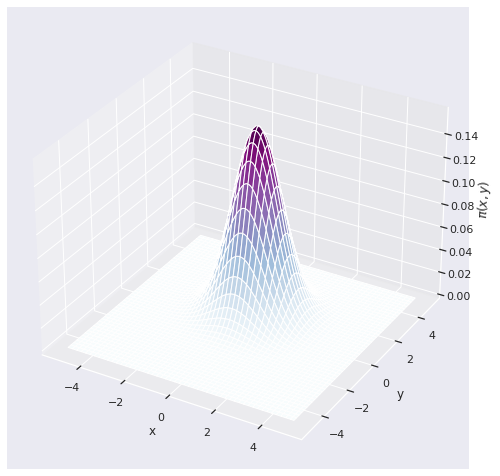

In [11]:
# create grid for 3D plot
x, y = np.linspace(-5, 5, 200), np.linspace(-5, 5, 200)
X,Y = np.meshgrid(x, y)

# generate bivariate normal 
Z = bivariate_normal(X,Y,var[0][0],var[1][1],mean[0],mean[1])

# plot surface in 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\pi(x,y)$')

### Definimos la 2D distribución objetivo:

In [12]:
def ptarget(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mean, cov=var)

### Construimos un método para el algoritmo Metropolis-Hastings, sus parámetros de entrada serán:
- p: distribución objetivo
- n: número de iteraciones del algoritmo
- x0, y0: punto de partida.
- step: tamaño del paso

In [13]:
def metropolis_hastings(p, n, x0, y0, step):
    x = x0
    y = y0
    
    points = np.zeros((n, 2)) # Lista inicial de muestras, al momento, con puros ceros

    for i in range(n):
        
        # Proponemos nuevos valores para el estado actual mediante el muestreo Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step,size=2)

        # Condición de Metropolis-Hastings
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # Se actualiza la lista de muestras
        points[i] = np.array([x, y])

    return points

/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1556: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


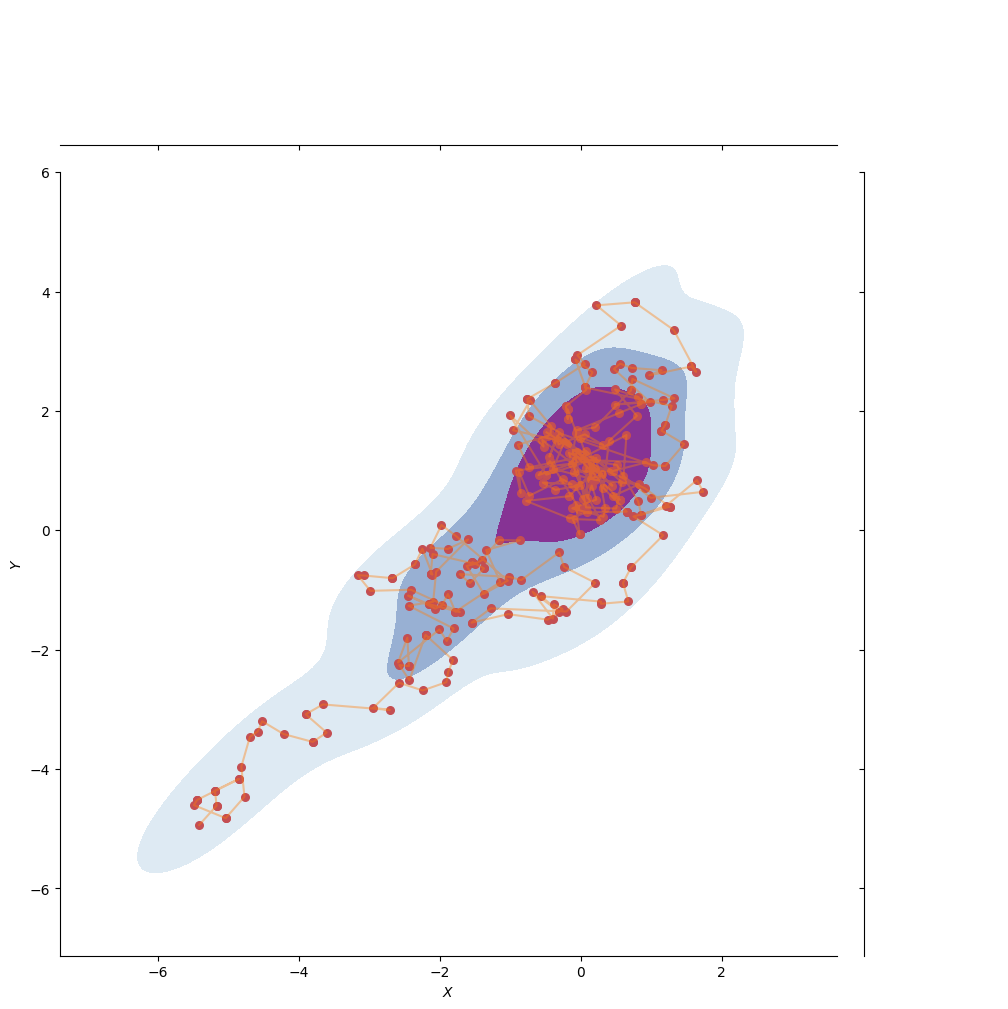

In [14]:
# generate the samples
samples = metropolis_hastings(ptarget, 300, -5, -5, 0.4)

# visualise 
plot_dist(samples[:, 0], samples[:, 1])
plt.savefig('caminates.png')



In [15]:
def simulated_annealing(p, n, x0, y0, step):
    '''Samples p, the target distribution, n times according to 
    the Metropolis-Hastings algorithm while Q(x'|x) becomes a narrower 
    distribution. This means exploration is increasingly localised 
    along the chain '''

    global step_size
    step_size = step
    
    def anneal(step):
        global step_size 
        step_size *= 0.99
        return step_size
        
    x = x0
    y = y0
    
    points = np.zeros((n, 2)) # list of samples to fill

    for i in range(n):
        
        # propose new parameters from current state by sampling Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step_size, size=2)

        # Metropolis-Hastings condition
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # update samples list
        points[i] = np.array([x, y])
        
        # reduce step size
        anneal(step_size)

    return points


/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1556: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


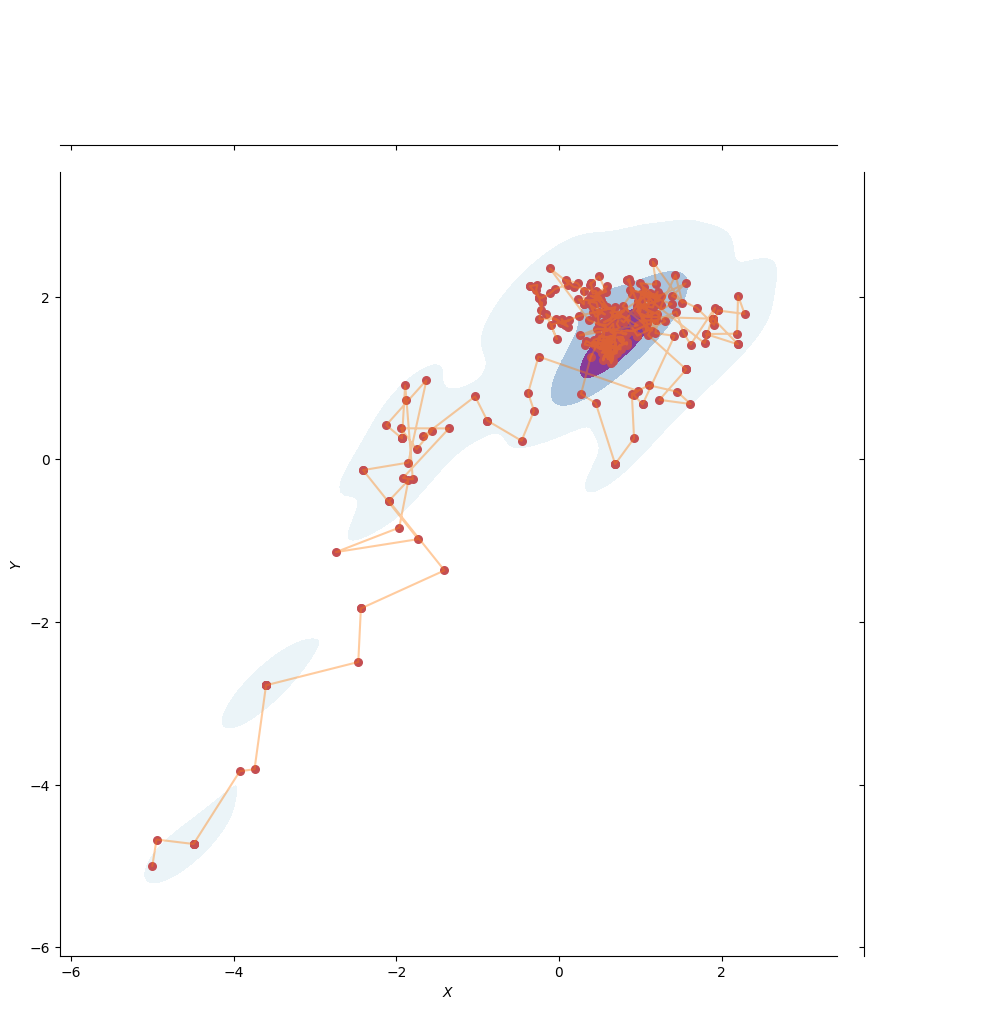

In [16]:
# generate the samples
samples = simulated_annealing(ptarget, 500, -5, -5, 0.8)

# visualise 
plot_dist(samples[:, 0], samples[:, 1])